In [ ]:
from utils_NXP_N7 import *  # noqa: F403,F401
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [6]:
from model_definition import create_model_CNN
# Charger les données
X_train, X_test, y_train, y_test = load_data(
    "data_processed/data_processeddata_df.csv",
    "data_processed/data_processedlabels_df.csv"
)

# Définir les paramètres du modèle
input_shape = X_train.shape[1:]  # Forme des données d'entrée
num_classes = len(np.unique(y_train))  # Nombre de classes pour la classification
model = create_model_CNN(input_shape, num_classes)
model.summary()

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 3286, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3286, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3286, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3286, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3286, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,576 (29.59 KB)

 Trainable params: 7,384 (28.84 KB)

 Non-trainable params: 192 (768.00 B)

In [3]:

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
# Définir les callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,            
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
]

In [5]:
# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    epochs=3000,
    batch_size=16,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/3000
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1960 - loss: 5.5857 - val_accuracy: 0.1140 - val_loss: 7.9030 - learning_rate: 0.0010
Epoch 2/3000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2467 - loss: 4.5503 - val_accuracy: 0.1491 - val_loss: 7.8758 - learning_rate: 0.0010
Epoch 3/3000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2841 - loss: 3.6593 - val_accuracy: 0.1579 - val_loss: 5.0215 - learning_rate: 0.0010
Epoch 4/3000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3987 - loss: 2.5497 - val_accuracy: 0.2456 - val_loss: 4.4802 - learning_rate: 0.0010
Epoch 5/3000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4163 - loss: 2.1985 - val_accuracy: 0.3596 - val_loss: 3.2454 - learning_rate: 0.0010
Epoch 6/3000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4670 - loss: 1.9618 - val_accuracy: 0.2544 - val_loss: 3.2675 - learning_rate: 0.0010
Epoch 7/3000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4361 - loss: 1.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9648 - loss: 0.1003
Test Loss: 0.10026603937149048, Test Accuracy: 0.9647887349128723
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Matrice de confusion :
 [[13  0  0  0  0  0  3  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  1  0]
 [ 0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0]
 [ 0  1  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0  0  0 11]]

Precision : 0.9714436155801741
Recall    : 0.9647887323943662
F1-score  : 0.9653476649145383


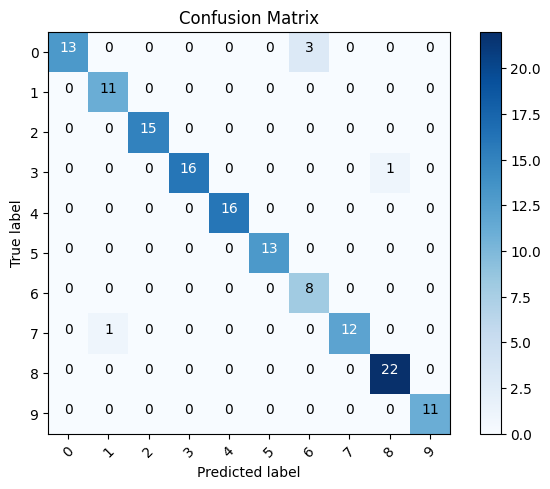

In [6]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


# # Matrice de confusion
# y_pred = np.argmax(model.predict(X_test), axis=-1)
# cm = tf.math.confusion_matrix(y_test, y_pred, num_classes = 10)

# cm = cm.numpy()

# Prédictions + matrice de confusion
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)

cm = tf.math.confusion_matrix(y_test, y_pred)
class_names = [str(c) for c in np.unique(y_train)]
cm = cm.numpy() 
print("\nMatrice de confusion :\n", cm)
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")


# Calcul des métriques : précision, rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print(f"\nPrecision : {precision}")
print(f"Recall    : {recall}")
print(f"F1-score  : {f1}")

In [6]:
# Suppresion de la derniere couche pour compatibilité NXP
model_trunc = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [9]:
# Sauvegarde du modèle
model_trunc.save("model_trunc_saved.keras")
print("model_trunc saved.")

model_trunc saved.


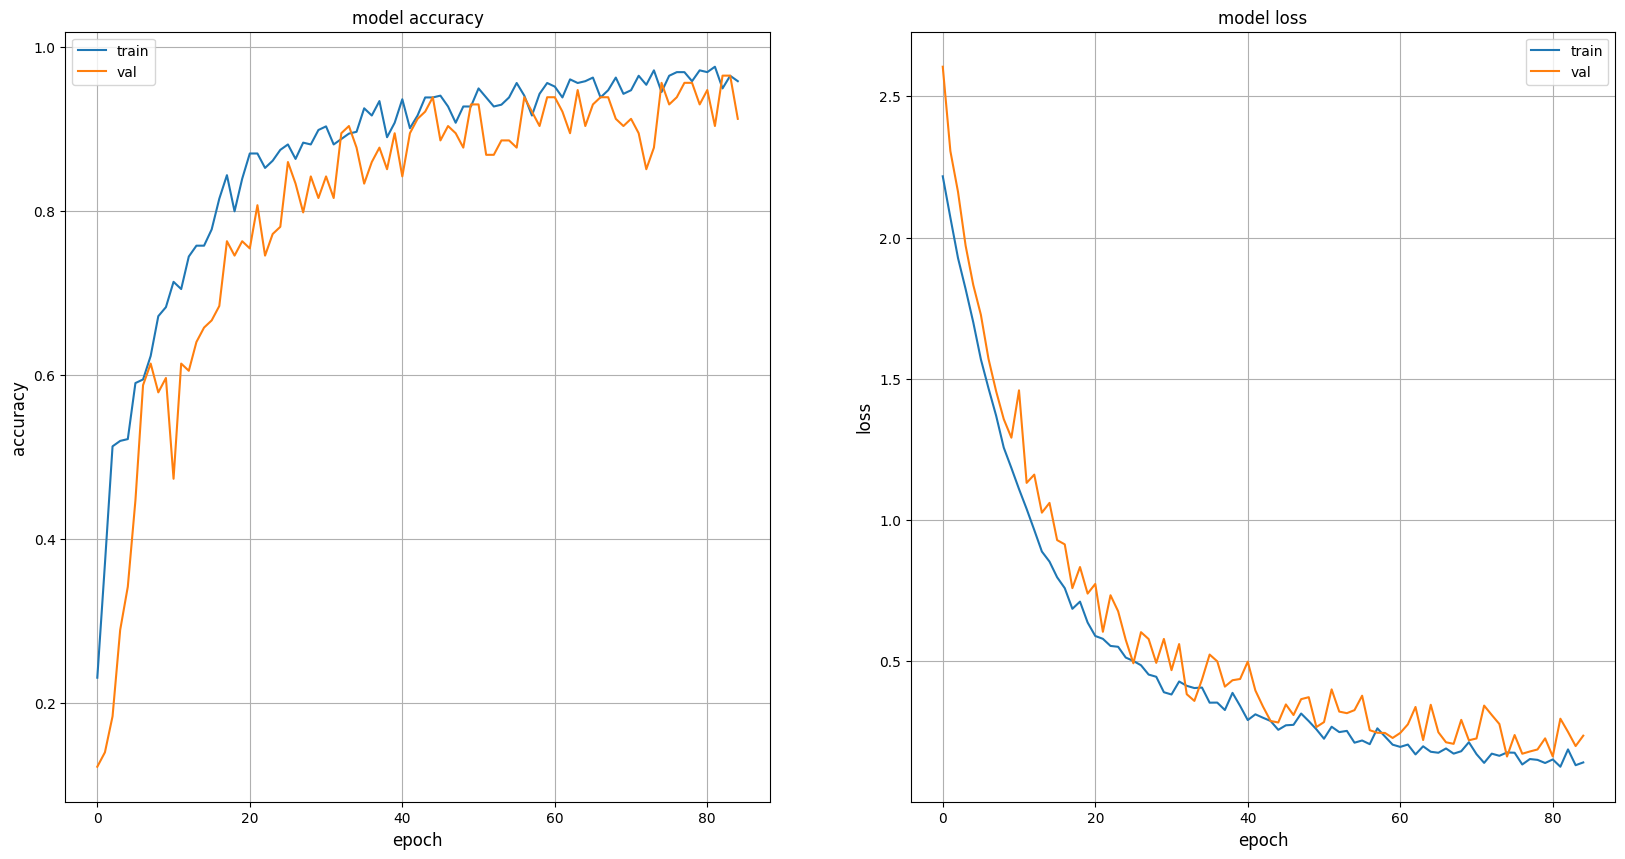

In [9]:
plot_scores(history)  # Plot validation accuracy

In [8]:
y_pred_full  = np.argmax(model.predict(X_test), axis=1)
y_pred_trunc = np.argmax(model_trunc.predict(X_test), axis=1)

# Vérifier combien de prédictions diffèrent
diff = np.mean(y_pred_full != y_pred_trunc)
print("Taux de prédictions différentes :", diff)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Taux de prédictions différentes : 0.9647887323943662


In [ ]:
# Model quantization

# Representative dataset generator
def representative_data_gen():
    for i in range(50): #X_test[:50]
        yield [X_train[i:i+1].astype(np.float32)]

# Créer le convertisseur TFLite à partir du modèle Keras sauvegardé
#converter = tf.lite.TFLiteConverter.from_keras_model(model_trunc)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Configurer la quantization int8 complète
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()

# Sauvegarder le modèle quantifié
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)
print("Quantized model saved as tflite_quant_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmp7s7606b3\assets


INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmp7s7606b3\assets


Saved artifact at 'C:\Users\BILAAA~1\AppData\Local\Temp\tmp7s7606b3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3286, 2), dtype=tf.float32, name='keras_tensor_112')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2527324720464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457398624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457615680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457614096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457399504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457614976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457623072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457621136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457618848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2525457628352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model saved as tflite_quant_model.tflite


In [19]:
# TensorFlow Lite Interpreter Setup
tflite_interpreter = tf.lite.Interpreter(model_path="tflite_quant_model.tflite")
tflite_interpreter.allocate_tensors()

# Insepect input and output details
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

# Quantization Parameters: Zero point and scale 
zero_point_input = input_details[0]['quantization_parameters']['zero_points'][0]
scale_input = input_details[0]['quantization_parameters']['scales'][0]

# Quantizing the test data
X_test_8 = np.round(X_test.astype(np.float32) / scale_input + zero_point_input).astype(np.uint8)

# Running Inference with the Quantized model
output_array = np.zeros((X_test.shape[0], 10))
for i in range(X_test.shape[0]):
    X = np.reshape(X_test_8[i], (1, X_test_8.shape[1], X_test_8.shape[2]))
    tflite_interpreter.set_tensor(input_details[0]['index'], X)
    tflite_interpreter.invoke()
    output_array[i] = tflite_interpreter.get_tensor(output_details[0]['index'])


output_details = tflite_interpreter.get_output_details()

zero_point_output = output_details[0]['quantization_parameters']['zero_points'][0]
scale_output      = output_details[0]['quantization_parameters']['scales'][0]

# Dequantizing the Output
y_pred_tflite = (output_array - zero_point_output) * scale_output
y_pred_tflite = np.argmax(y_pred_tflite, axis=1)



c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


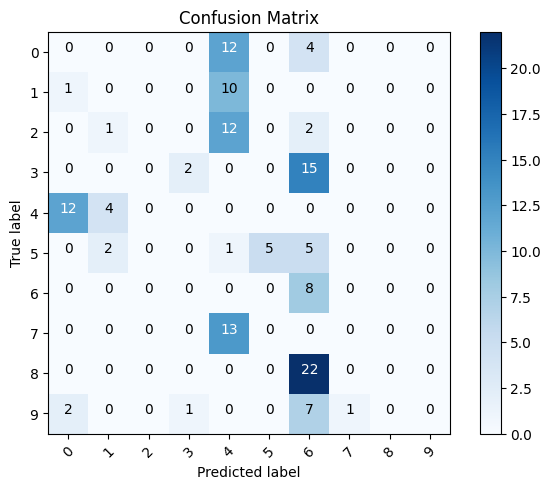

In [21]:
# Matrice de confusion pour le modèle quantifié
cm = tf.math.confusion_matrix(y_test, y_pred_tflite)
class_names = [str(c) for c in np.unique(y_train)]
cm = cm.numpy() 

plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")

In [ ]:
import tensorflow as tf

# Load the trained Keras model
model = tf.keras.models.load_model('model_saved.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# --- For Full Integer Quantization ---
# 1. Provide the representative dataset generator
def representative_dataset_gen():
    # Example: Yield a few sample input tensors
    for input_value in X_train.take(100):
        yield [input_value]

converter.representative_dataset = representative_dataset_gen
# 2. Specify the target operations and I/O types
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Set input/output to INT8/UINT8 for full speed
converter.inference_output_type = tf.uint8

quantized_tflite_model = converter.convert()

# Save the TFLite model
with open('my_quantized_int8_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)